In [1]:
import deepSI
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
from deepSI import System_data, System_data_list

## Data generation

Creating some data for the system

$$
x_{t+1} = a x_t + u_t\\
y_t = x_t
$$

with $a=0.5$

In [2]:
class my_sys(deepSI.System_ss): #a simple state-space wrapper of the general System class
    def __init__(self, a=0.5):
        super(my_sys, self).__init__(nx=1)
        self.a = a
    
    def f(self, x, u):
        return self.a*x + u
    
    def h(self,x,u):
        return x[0]

a_now = 0.5
sys = my_sys(a=a_now)
data = sys.sample_system(N_sampes=10000) #uniform -1,1 
train, test = data.train_test_split()
train, val = train.train_test_split()
print('train:\t', train)
print('val:\t', val)
print('test:\t', test)

train:	 System_data of length: 5625 nu=None ny=None normed=False dt=None
val:	 System_data of length: 1875 nu=None ny=None normed=False dt=None
test:	 System_data of length: 2500 nu=None ny=None normed=False dt=None


## Creating a custom encoder, $f_\theta$, $g_\theta$ for this sytem.

In [3]:
class my_encoder_net(nn.Module): #a simple FC net with a residual (defaulth appraoch)
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(my_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod(self.ny,dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class my_lin_encoder_net(nn.Module): #linear encoder appraoch
    def __init__(self, nb, nu, na, ny, nx, b0=0.5):
        super(my_lin_encoder_net, self).__init__()
        self.b = nn.Parameter(data=torch.as_tensor(b0))

    def forward(self, upast, ypast):
        #first dimention is always the batch dimension (Nb)
        #upast shape: (Nb, nb)
        #ypast shape: (Nb, na)
        return (upast[:,-1] + self.b*ypast[:,-1])[:,None]

class my_state_net(nn.Module): #
    def __init__(self, nx, nu, a0=0.5):
        super(my_state_net, self).__init__()
        self.a = nn.Parameter(data=torch.as_tensor(a0))

    def forward(self, x, u):
        #first dimention is always the batch dimention
        # x shape: (Nb, 1)
        # u shape: (Nb)
        return x*self.a + u[:,None]

class my_output_net(nn.Module):
    def __init__(self, nx, ny):
        super(my_output_net, self).__init__()

    def forward(self, x, u=None):
        #first dimention is always the batch dimention
        return x[:,0] #(Nb,nx)

## test if this setup can reproduce the data

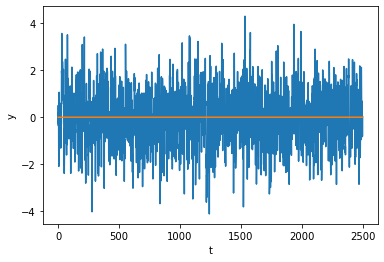

3.158645231422938e-08

In [4]:

fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, na=1, nb=1, \
                                                e_net=my_lin_encoder_net, e_net_kwargs=dict(b0=a_now),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now),\
                                                h_net=my_output_net)
fit_sys.init_model(nu=None, ny=None) #init the network callaed as e_net(**e_net_kwargs) 
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
test_p.NRMS(test) #3.2e-8

# Fitting with linear encoder

In [5]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, e_net=my_lin_encoder_net, e_net_kwargs=dict(b0=a_now*0.9),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now*0.9),\
                                                h_net=my_output_net)
fit_sys.init_model(nu=None,ny=None)
fit_sys.fit(train,val, epochs=100, loss_kwargs=dict(nf=25), auto_fit_norm=False, optimizer_kwargs=dict(betas=(0.99,0.999))) #nf = T in the paper


Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  2.9 MB
N_training_samples = 5581, batch_size = 256, N_batch_updates_per_epoch = 21
Initial Validation sim-NRMS= 0.07146040872594304


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.04328681969163392
Epoch    1, sqrt loss 0.06567, Val sim-NRMS 0.04329, Time Loss: 73.1%, data: 1.5%, val: 25.3%, 58.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.019382261015877134
Epoch    2, sqrt loss 0.03592, Val sim-NRMS 0.01938, Time Loss: 67.5%, data: 1.6%, val: 30.9%, 78.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0046766883511966525
Epoch    3, sqrt loss 0.01376, Val sim-NRMS 0.004677, Time Loss: 62.0%, data: 1.3%, val: 36.6%, 87.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.00046241809797717946
Epoch    4, sqrt loss 0.002454, Val sim-NRMS 0.0004624, Time Loss: 58.2%, data: 1.3%, val: 40.5%, 88.5 batches/sec
Epoch    5, sqrt loss 0.0008716, Val sim-NRMS 0.000705, Time Loss: 56.2%, data: 1.2%, val: 42.6%, 94.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS

Epoch   60, sqrt loss 4.502e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.4%, data: 2.2%, val: 51.3%, 113.9 batches/sec
Epoch   61, sqrt loss 4.495e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.4%, data: 2.2%, val: 51.4%, 114.0 batches/sec
Epoch   62, sqrt loss 4.502e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.4%, data: 2.2%, val: 51.4%, 113.9 batches/sec
Epoch   63, sqrt loss 4.499e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.2%, data: 2.2%, val: 51.5%, 113.7 batches/sec
Epoch   64, sqrt loss 4.49e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.3%, data: 2.2%, val: 51.4%, 113.5 batches/sec
Epoch   65, sqrt loss 4.496e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.2%, data: 2.3%, val: 51.5%, 113.9 batches/sec
Epoch   66, sqrt loss 4.507e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.2%, data: 2.2%, val: 51.5%, 114.0 batches/sec
Epoch   67, sqrt loss 4.502e-08, Val sim-NRMS 3.335e-08, Time Loss: 46.2%, data: 2.2%, val: 51.5%, 113.8 batches/sec
Epoch   68, sqrt loss 4.496e-08, Val sim-NRMS 3.335e-08, Time Los

### Results

a fitted: 0.5  real a: 0.5
b fitted: 0.4999999701976776  real b: 0.5


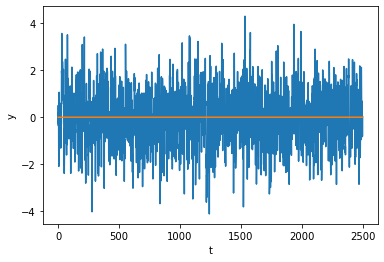

NRMS= 3.1667110017225014e-08


In [6]:
print('a fitted:', fit_sys.fn.a.item(), ' real a:',a_now)
print('b fitted:', fit_sys.encoder.b.item(), ' real b:',a_now)
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
print('NRMS=',test_p.NRMS(test)) #1.0e-7

# Nonlinear encoder

In [7]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, na=2, nb=2,\
                                                e_net=my_encoder_net, e_net_kwargs=dict(),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now*0.9),\
                                                h_net=my_output_net)
fit_sys.init_model(nu=None,ny=None)
fit_sys.fit(train, val, epochs=100, loss_kwargs=dict(nf=25), auto_fit_norm=False, optimizer_kwargs=dict(betas=(0.99,0.999))) #nf = T in the paper


Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  1.7 MB
N_training_samples = 5599, batch_size = 256, N_batch_updates_per_epoch = 21
Initial Validation sim-NRMS= 0.07240114130760966


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.04330353569637711
Epoch    1, sqrt loss  0.1836, Val sim-NRMS 0.0433, Time Loss: 58.7%, data: 4.0%, val: 37.3%, 87.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.020700631636655954
Epoch    2, sqrt loss 0.07987, Val sim-NRMS 0.0207, Time Loss: 57.7%, data: 2.4%, val: 39.9%, 97.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.005213502823259933
Epoch    3, sqrt loss 0.04982, Val sim-NRMS 0.005214, Time Loss: 56.1%, data: 1.8%, val: 41.9%, 103.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0005706028856161037
Epoch    4, sqrt loss  0.0434, Val sim-NRMS 0.0005706, Time Loss: 57.3%, data: 1.8%, val: 40.9%, 100.9 batches/sec
Epoch    5, sqrt loss  0.0411, Val sim-NRMS 0.001029, Time Loss: 55.5%, data: 1.5%, val: 42.1%, 97.4 batches/sec
Epoch    6, sqrt loss 0.03911, Val sim-NRMS 0.000707, Time Loss: 54.5%, 

Epoch   63, sqrt loss 0.003642, Val sim-NRMS 5.424e-05, Time Loss: 53.9%, data: 2.4%, val: 43.6%, 105.2 batches/sec
Epoch   64, sqrt loss 0.00376, Val sim-NRMS 0.0003474, Time Loss: 53.9%, data: 2.4%, val: 43.5%, 105.5 batches/sec
Epoch   65, sqrt loss 0.003717, Val sim-NRMS 0.0003707, Time Loss: 53.9%, data: 2.5%, val: 43.5%, 105.5 batches/sec
Epoch   66, sqrt loss 0.003681, Val sim-NRMS 0.0002579, Time Loss: 53.9%, data: 2.5%, val: 43.6%, 105.8 batches/sec
Epoch   67, sqrt loss 0.003684, Val sim-NRMS 0.0003119, Time Loss: 53.8%, data: 2.4%, val: 43.7%, 105.7 batches/sec
Epoch   68, sqrt loss 0.003682, Val sim-NRMS 0.0001177, Time Loss: 53.7%, data: 2.4%, val: 43.8%, 105.3 batches/sec
Epoch   69, sqrt loss 0.003551, Val sim-NRMS 5.304e-05, Time Loss: 53.7%, data: 2.4%, val: 43.8%, 105.1 batches/sec
Epoch   70, sqrt loss 0.003503, Val sim-NRMS 0.0001248, Time Loss: 53.7%, data: 2.5%, val: 43.7%, 105.2 batches/sec
Epoch   71, sqrt loss 0.003495, Val sim-NRMS 8.061e-05, Time Loss: 53.7%,

## Results nonlinear encoder

a fitted: 0.499997079372406  real a: 0.5


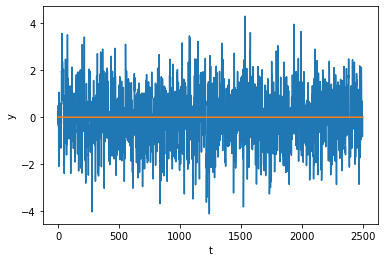

NRMS: 0.00021692842094731137


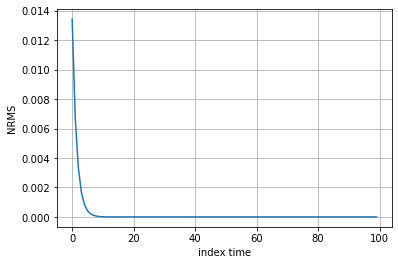

In [8]:
print('a fitted:', fit_sys.fn.a.item(), ' real a:',a_now)
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
print('NRMS:',test_p.NRMS(test)) #1.0e-7
fit_sys.n_step_error_plot(test) #encoder isn't perfect but it works